<a href="https://www.kaggle.com/code/quangnguynngnht/e-commerce-sales-analysis-and-forecasting?scriptVersionId=182149832" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# E-commerce Sales Analysis and Forecasting

In [1]:
import warnings
warnings.filterwarnings("ignore")

### Import Necessary Libraries

In [2]:
# %pip install prophet

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from sklearn.metrics import davies_bouldin_score, silhouette_score, mean_absolute_error, mean_squared_error
import numpy as np

### Load the Dataset

In [4]:
data = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding='ISO-8859-1')
# Display the first few rows of the dataset
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


## Basic Statistics and Missing Values

In [5]:
# Basic statistics
print(data.describe())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [6]:
# Check for missing values
print(data.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## Data Cleaning

In [7]:
# Drop rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Add a column for total price
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
# Remove negative Quantity and UnitPrice
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

## Exploratory Data Analysis (EDA)

### Time series analysis: Sales over time (monthly)

In [8]:
data.set_index('InvoiceDate', inplace=True)
monthly_sales = data['TotalPrice'].resample('ME').sum()

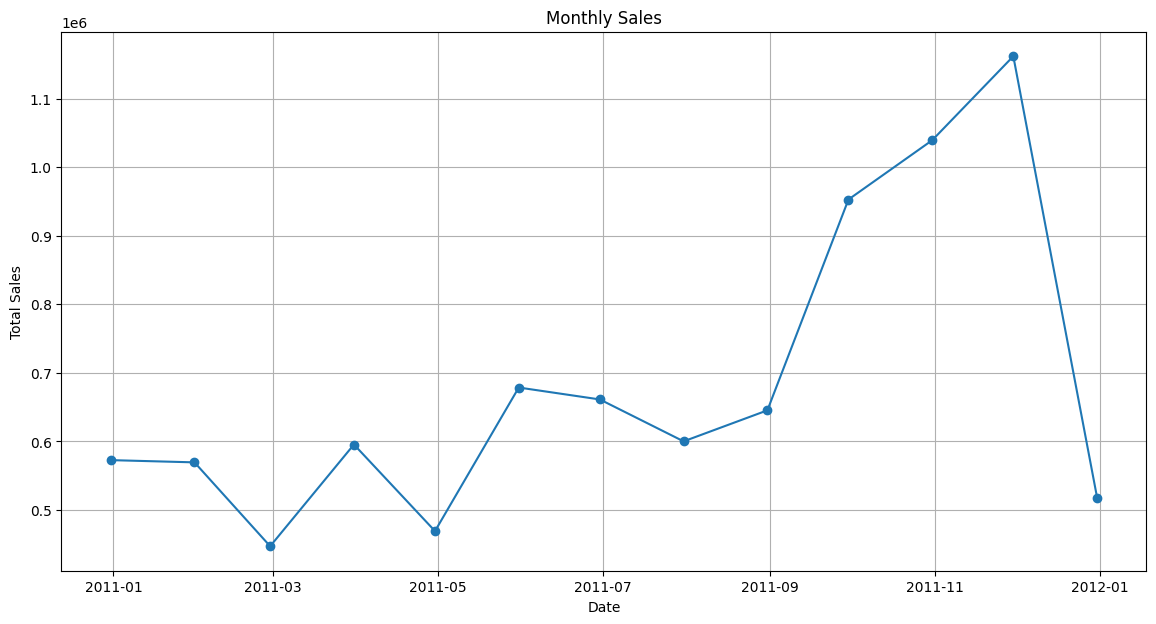

In [9]:
# Plot monthly sales
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales, marker='o')
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

The monthly sales plot shows a seasonal pattern with peaks and troughs, indicating that sales vary throughout the year.

### Top selling products

In [10]:
top_products = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

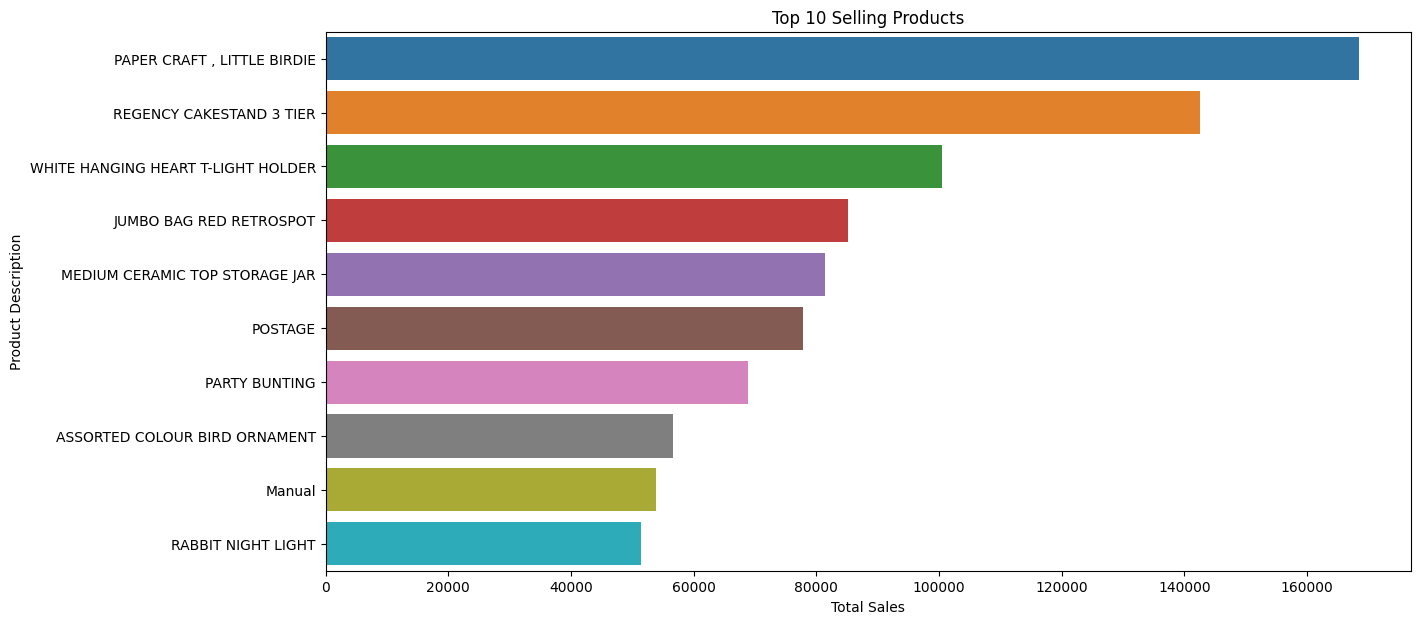

In [11]:
# Plot top selling products
plt.figure(figsize=(14, 7))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Selling Products')
plt.xlabel('Total Sales')
plt.ylabel('Product Description')
plt.show()

The bar plot reveals the top 10 selling products. These are the most popular items and inventory management and marketing efforts should be prioritized for these products.

### Sales by country

In [12]:
country_sales = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

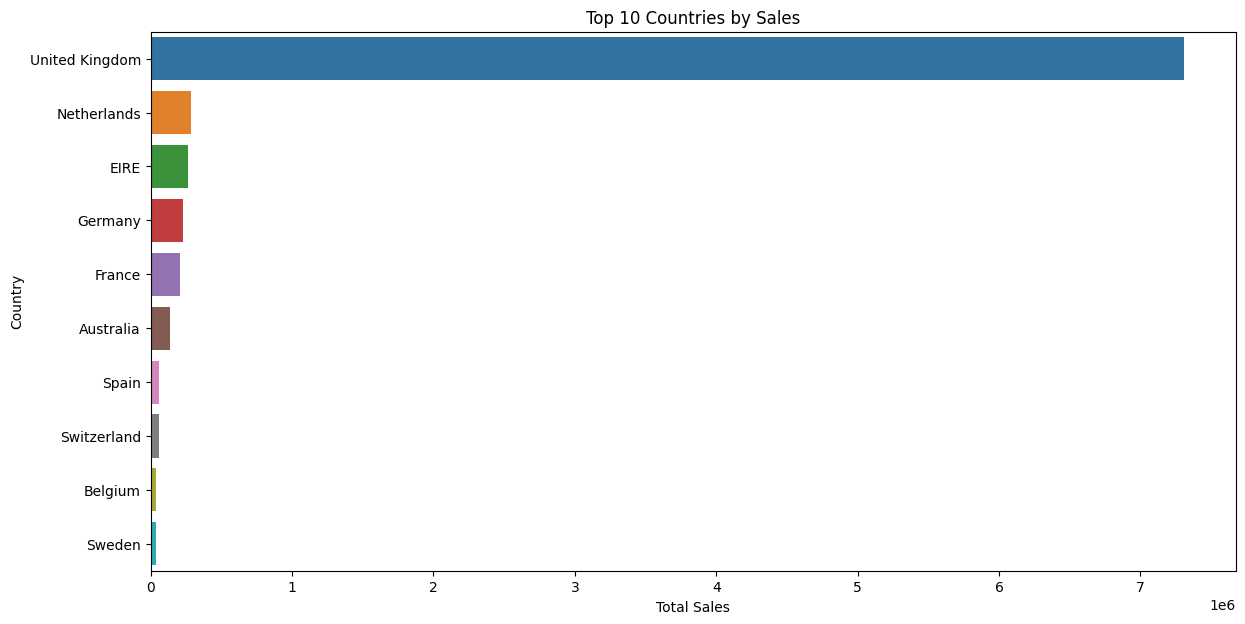

In [13]:
# Plot sales by country
plt.figure(figsize=(14, 7))
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title('Top 10 Countries by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Country')
plt.show()

The bar plot displays the top 10 countries by sales. We can see that UK is clearly the lead, taking up most of the profit. This is not unexpected as this is a UK company. However, we can also see that Netherlands, Ireland, Germany, and France the top performing international markets for the business. It seems like most of the customers are in Europe

### Customer Sales Analysis and Segmentation

In [14]:
customer_sales = data.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)

In [15]:
# Basic statistics on customer sales
customer_sales.describe()

count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: TotalPrice, dtype: float64

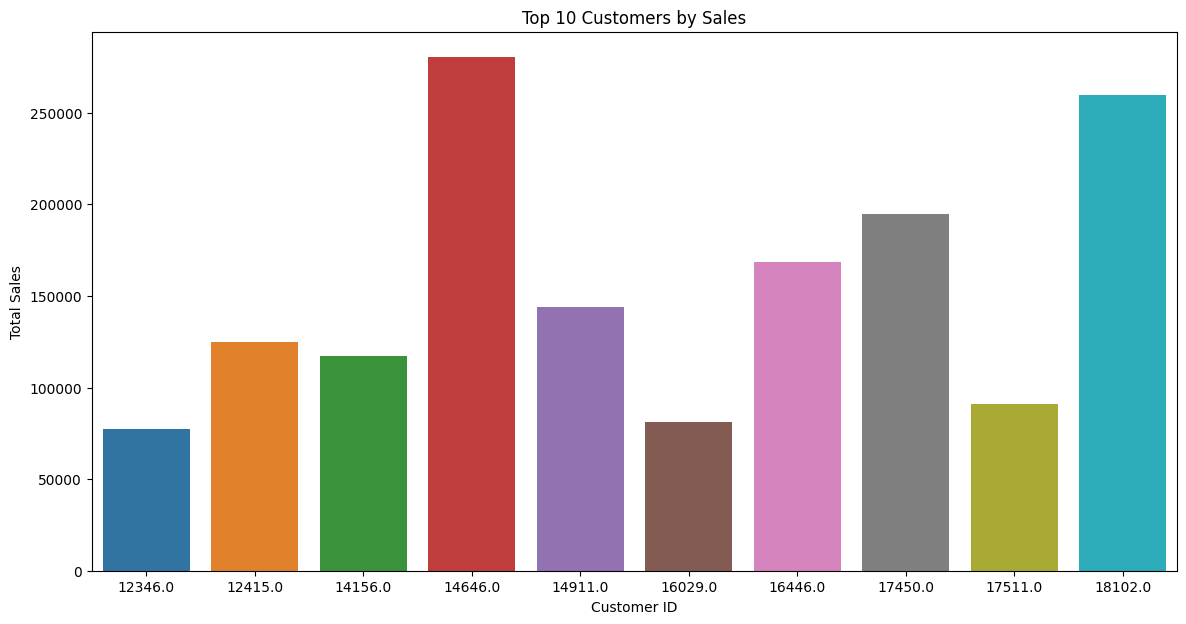

In [16]:
# Plot top customers
plt.figure(figsize=(14, 7))
sns.barplot(y=customer_sales.head(10).values, x=customer_sales.head(10).index)
plt.title('Top 10 Customers by Sales')
plt.ylabel('Total Sales')
plt.xlabel('Customer ID')
plt.show()

These top customers seems to be having extremely high number of sales compared to the mean of 2054 and median of just 674. This suggests that there are very different groups of customers with very different purchasing behaviour

### Summary of findings

In [17]:
print("Summary of Findings:")
print(f"Total Sales: {data['TotalPrice'].sum()}")
print(f"Total Transactions: {len(data)}")
print(f"Top Selling Product: {top_products.index[0]} with sales of {top_products.values[0]:.2f}")
print(f"Top Customer: {customer_sales.index[0]} with sales of {customer_sales.values[0]:.2f}")
print(f"Top Country: {country_sales.index[0]} with sales of {country_sales.values[0]:.2f}")

Summary of Findings:
Total Sales: 8911407.904
Total Transactions: 397884
Top Selling Product: PAPER CRAFT , LITTLE BIRDIE with sales of 168469.60
Top Customer: 14646.0 with sales of 280206.02
Top Country: United Kingdom with sales of 7308391.55


## Customer Segmentation Using KMeans Clustering

### Prepare data for clustering

In [18]:
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

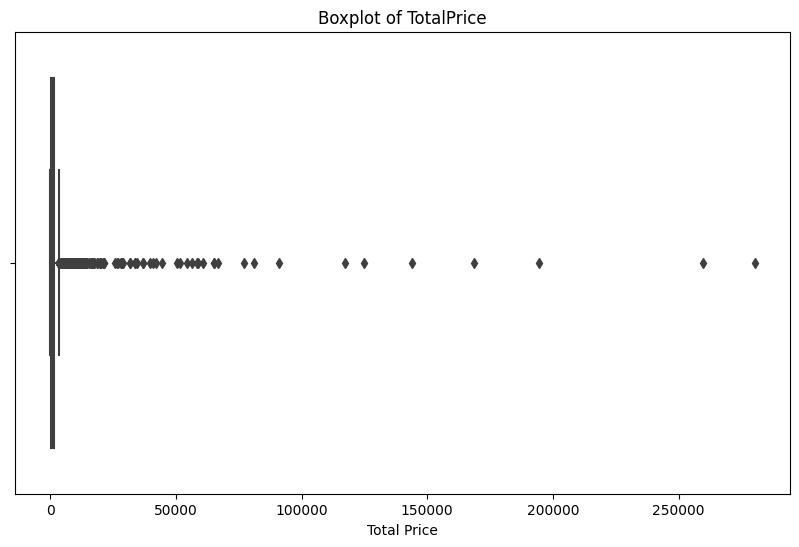

In [19]:
# Boxplot to visualize distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x=customer_data['TotalPrice'])
plt.title('Boxplot of TotalPrice')
plt.xlabel('Total Price')
plt.show()

We can see that there seems to be a lot of outliners and even data less than 0 - should not be considered. We will continue on filtering the data to cut out some of the outliners

In [20]:
# Filter data
filtered_customer_data = customer_data[(customer_data['TotalPrice'] > 0) & (customer_data['Quantity'] > 0) & (customer_data['TotalPrice'] < 150000)]

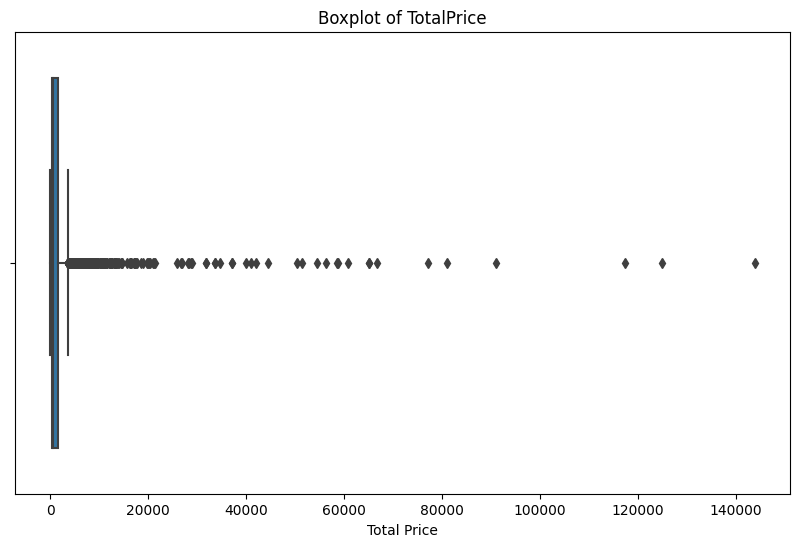

In [21]:
# Boxplot to visualize distribution after filtering
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_customer_data['TotalPrice'])
plt.title('Boxplot of TotalPrice')
plt.xlabel('Total Price')
plt.show()

In [22]:
# Convert inf values to NaN before plotting
filtered_customer_data['TotalPrice'].replace([np.inf, -np.inf], np.nan)

0       77183.60
1        4310.00
2        1797.24
3        1757.55
4         334.40
          ...   
4333      180.60
4334       80.82
4335      178.05
4336     2094.88
4337     1837.28
Name: TotalPrice, Length: 4334, dtype: float64

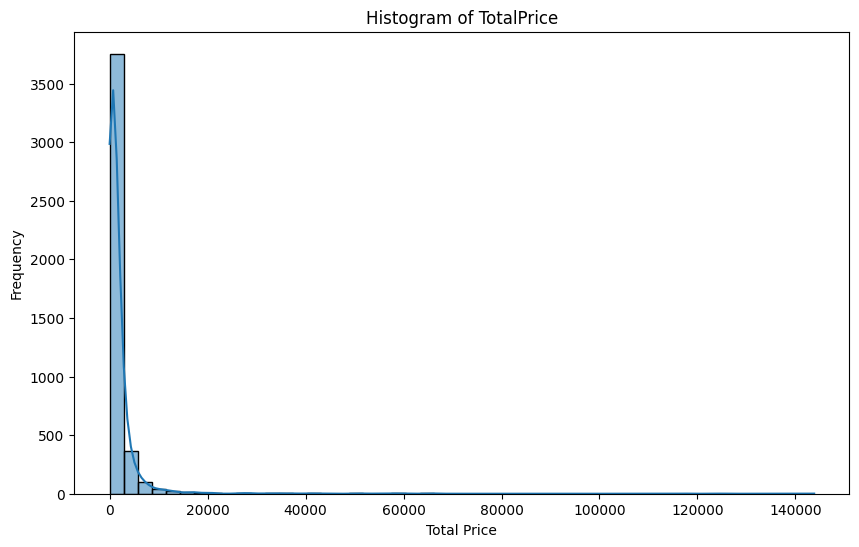

In [23]:
# Histogram to visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_customer_data['TotalPrice'], bins=50, kde=True)
plt.title('Histogram of TotalPrice')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Normalize the filtered data
scaler = StandardScaler()
# Perform standardization
scaled_values = scaler.fit_transform(filtered_customer_data[['Quantity', 'TotalPrice']])
# Explicitly cast the scaled values to a compatible dtype
filtered_customer_data[['Quantity', 'TotalPrice']] = scaled_values.astype('float64')

# Print the first few rows to verify the changes
print(filtered_customer_data.head())

   CustomerID   Quantity  TotalPrice
0     12346.0  20.157638   13.170919
1     12347.0   0.375123    0.430459
2     12348.0   0.342867   -0.008846
3     12349.0  -0.128559   -0.015785
4     12350.0  -0.248207   -0.264593


### Elbow Method to determine the optimal number of clusters

In [25]:
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=0, n_init='auto')
    kmeans.fit(filtered_customer_data[['Quantity', 'TotalPrice']])
    inertia.append(kmeans.inertia_)

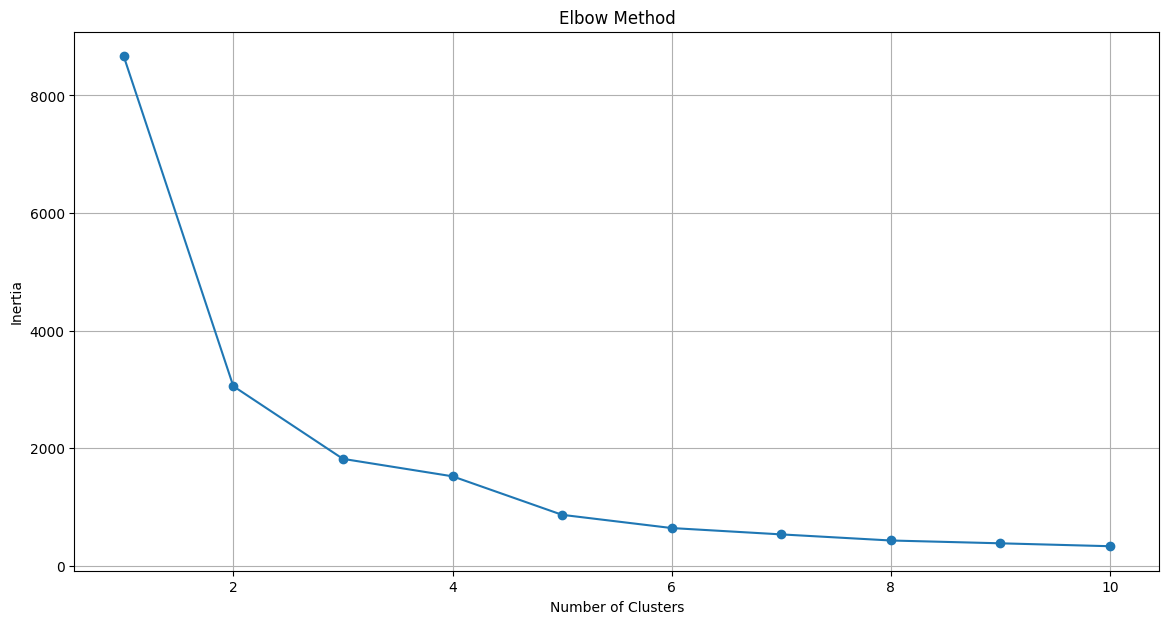

In [26]:
# Plot the Elbow Method
plt.figure(figsize=(14, 7))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

The elbow plot suggests that the optimal number of clusters for customer segmentation is 2, based on the point where the inertia (within-cluster sum of squares) starts to decrease more gradually.

### Cluster using KMeans

In [27]:
# Initialize KMeans with 2 clusters
kmeans_filtered = KMeans(n_clusters=2, random_state=0)

# Fit KMeans and assign cluster labels
filtered_customer_data['Cluster'] = kmeans_filtered.fit_predict(filtered_customer_data[['Quantity', 'TotalPrice']])

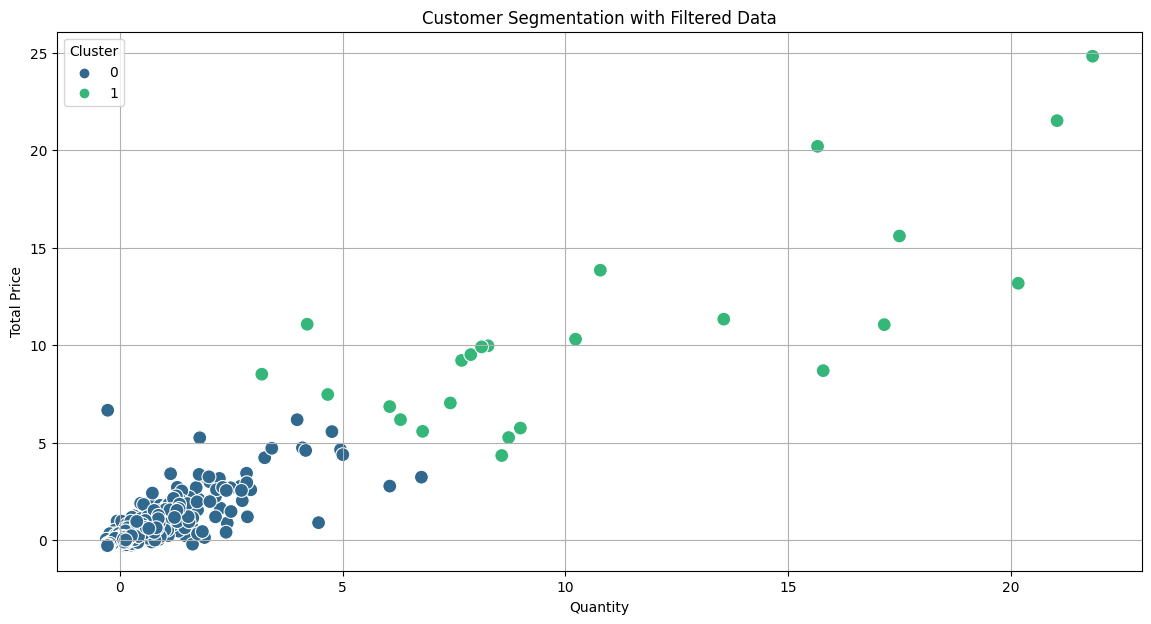

In [28]:
# Plot the clusters
plt.figure(figsize=(14, 7))
sns.scatterplot(data=filtered_customer_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation with Filtered Data')
plt.xlabel('Quantity')
plt.ylabel('Total Price')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

The scatter plot shows the two clusters identified by the KMeans algorithm, separating customers into a low-value cluster (Cluster 0) and a high-value cluster (Cluster 1) based on their quantity and total price.

### Evaluate the model

In [29]:
# Calculate silhouette score
silhouette_avg_filtered = silhouette_score(filtered_customer_data[['Quantity', 'TotalPrice']], filtered_customer_data['Cluster'])
print(f"Silhouette Score with filtered data: {silhouette_avg_filtered}")

Silhouette Score with filtered data: 0.965349604604783


In [30]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(filtered_customer_data[['Quantity', 'TotalPrice']], filtered_customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.4452041180746994


### Summary of clusters

In [31]:
cluster_summary_filtered = filtered_customer_data.groupby('Cluster').agg({
    'Quantity': 'mean',
    'TotalPrice': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()
print(cluster_summary_filtered)

   Cluster   Quantity  TotalPrice  Count
0        0  -0.060442   -0.059648   4310
1        1  10.854319   10.711834     24


In [32]:
# Reverse the normalization to get actual values
quantity_mean = scaler.mean_[0]
quantity_std = scaler.scale_[0]
totalprice_mean = scaler.mean_[1]
totalprice_std = scaler.scale_[1]

cluster_summary_filtered['Quantity'] = (cluster_summary_filtered['Quantity'] * quantity_std) + quantity_mean
cluster_summary_filtered['TotalPrice'] = (cluster_summary_filtered['TotalPrice'] * totalprice_std) + totalprice_mean

In [33]:
# Print the actual values
print(cluster_summary_filtered)

   Cluster      Quantity    TotalPrice  Count
0        0    878.079814   1506.656537   4310
1        1  40469.125000  63117.984167     24


### Key Insights and Recommendations

#### Cluster 0: Low-Value Customers

This cluster represents the majority of customers with relatively low average quantities and total prices. These customers are likely occasional shoppers or those who make small, infrequent purchases. To better serve and retain these customers, the following recommendations can be considered:

- **Offer promotional discounts and bundled deals**: Encourage these customers to increase their order sizes by offering discounts or bundled deals on frequently purchased items.
- **Implement a loyalty program**: Introduce a loyalty program with rewards or incentives for repeat purchases to foster customer retention and encourage more frequent shopping.
- **Targeted marketing campaigns**: Analyze purchase patterns and preferences to create targeted marketing campaigns promoting relevant products or categories.

#### Cluster 1: High-Value Customers

This cluster consists of a small group of high-value customers with extremely high average quantities and total prices. These customers are likely businesses, resellers, or individuals with specific high-volume needs. To better cater to and retain these valuable customers, the following recommendations can be considered:

- **Dedicated account management**: Assign dedicated account managers or customer service representatives to provide personalized support and address their unique needs.
- **Bulk discounts and special pricing**: Offer bulk discounts or special pricing for high-volume orders to incentivize these customers and maintain their loyalty.
- **Enhanced product offerings**: Explore expanding product offerings or introducing specialized product lines tailored to their specific needs or industries.

## Time Series Forecasting Using Prophet

### Prepare the data for Prophet
The code filters out zero sales days and removes outliers using the IQR method, followed by log transformation of the sales data.

In [34]:
# Time series analysis: Sales over time (daily)
daily_sales = data['TotalPrice'].resample('D').sum()
# Convert daily_sales to DataFrame
daily_sales = daily_sales.reset_index()

In [35]:
daily_sales.columns = ['ds', 'y']

#### Adressing outliners

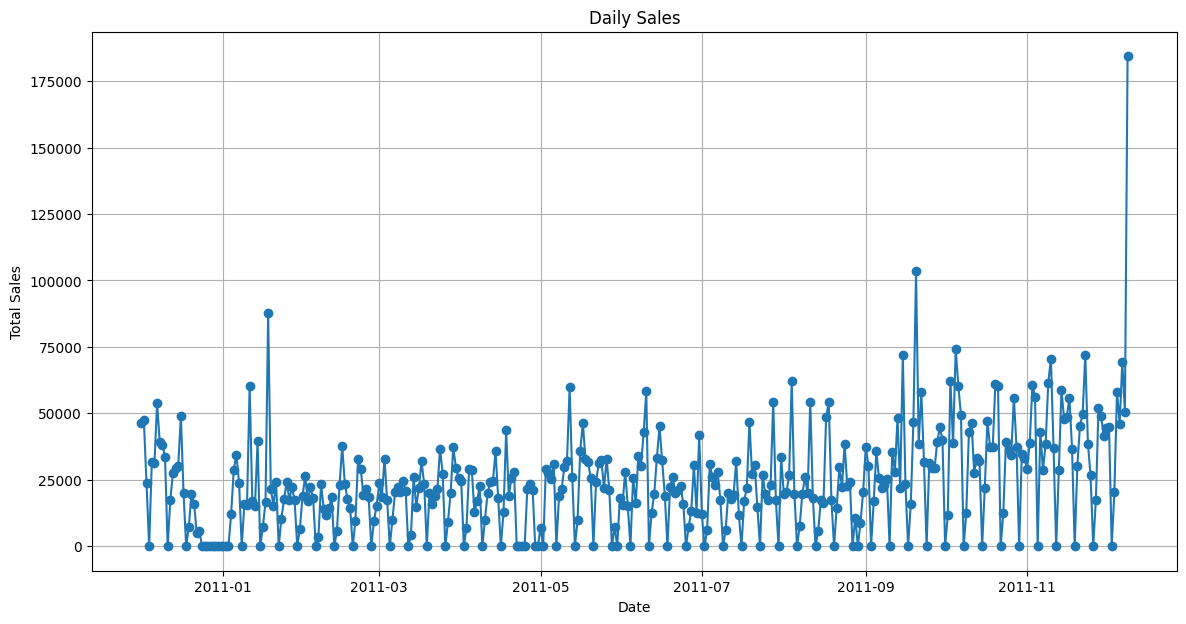

In [36]:
# Plot daily sales to identify outliers
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['ds'], daily_sales['y'], marker='o')
plt.title('Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [37]:
# Remove days with zero sales
daily_sales = daily_sales[daily_sales['y'] > 0]

In [38]:
# Use IQR method to remove outliers
Q1 = daily_sales['y'].quantile(0.25)
Q3 = daily_sales['y'].quantile(0.75)
IQR = Q3 - Q1
filtered_sales = daily_sales[~((daily_sales['y'] < (Q1 - 1.5 * IQR)) | (daily_sales['y'] > (Q3 + 1.5 * IQR)))]

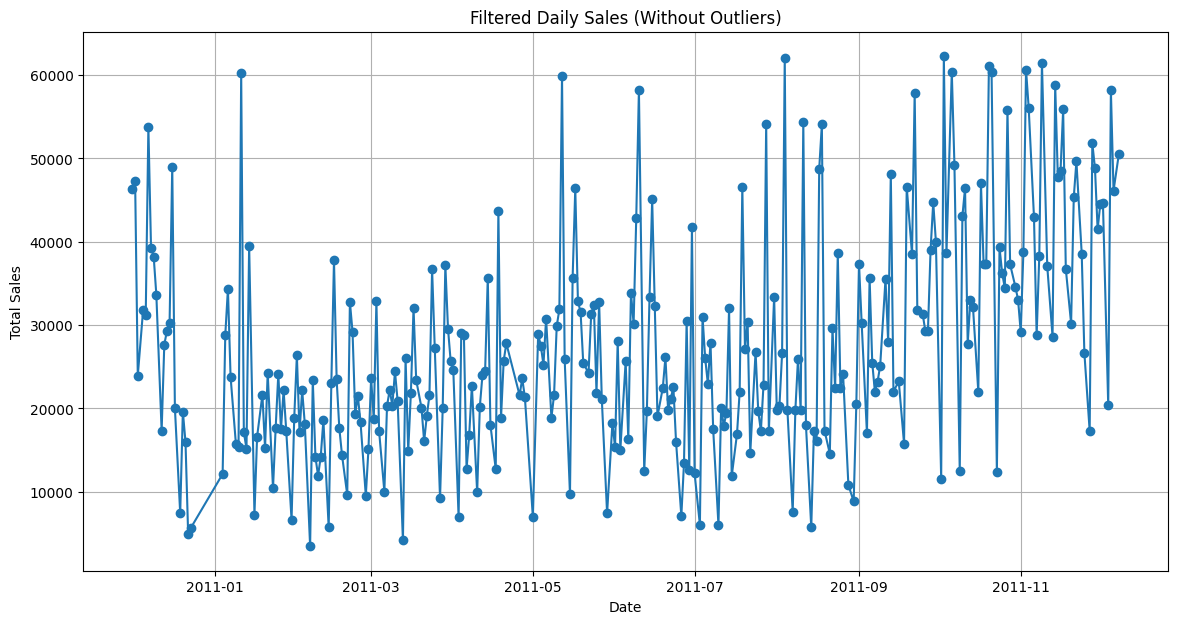

In [39]:
# Plot filtered sales data to confirm outliers are removed
plt.figure(figsize=(14, 7))
plt.plot(filtered_sales['ds'], filtered_sales['y'], marker='o')
plt.title('Filtered Daily Sales (Without Outliers)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

#### Log transformation

In [40]:
filtered_sales['y'] = np.log1p(filtered_sales['y']).values

### Model Training
The Prophet model is trained on the filtered sales data, incorporating day of the week and weekend as additional regressors.

In [41]:
# Adding regressors
filtered_sales['day_of_week'] = filtered_sales['ds'].dt.day_of_week.values
filtered_sales['is_weekend'] = filtered_sales['day_of_week'].isin([6]).values  # Sunday

In [42]:
# Split the data into train and test sets
train = filtered_sales[:-60]
test = filtered_sales[-60:]
# Check the total number of data points
print(f"Total number of data points: {len(filtered_sales)}")
print(f"Number of training data points: {len(train)}")
print(f"Number of testing data points: {len(test)}")

Total number of data points: 297
Number of training data points: 237
Number of testing data points: 60


In [43]:
# Train the model
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
model.add_regressor('day_of_week')
model.add_regressor('is_weekend')
model.fit(train)

04:11:50 - cmdstanpy - INFO - Chain [1] start processing
04:11:50 - cmdstanpy - INFO - Chain [1] done processing


### Make forecast with the Prophet model
The plots showcase the sales forecast using the Prophet model, as well as the forecast components (trend, weekly, and yearly seasonality).

In [44]:
# Make future dataframe for the test period
future = model.make_future_dataframe(periods=60, freq='D')
future['day_of_week'] = future['ds'].dt.day_of_week
future['is_weekend'] = future['ds'].dt.day_of_week.isin([6])

forecast = model.predict(future)

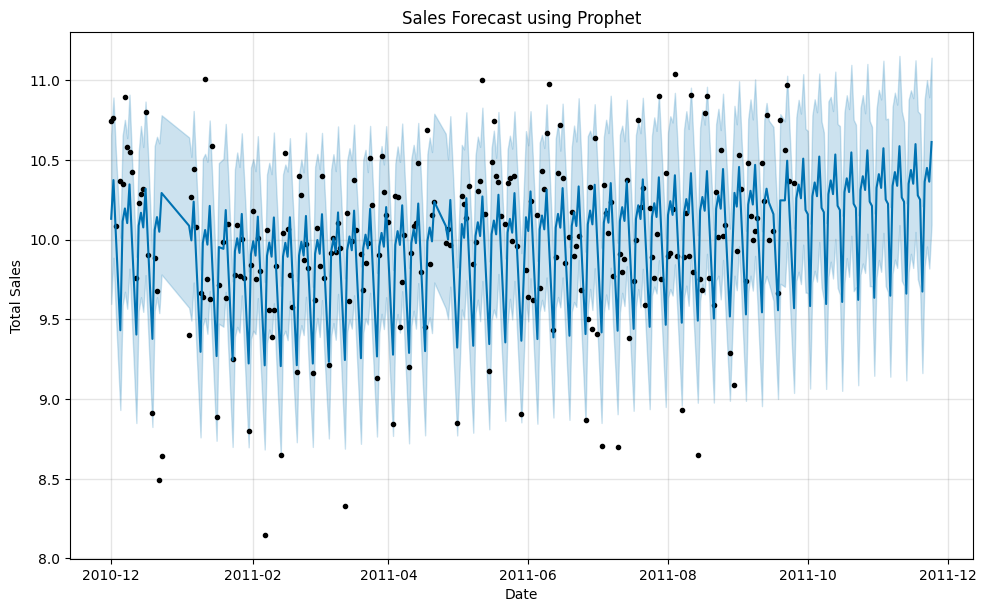

In [45]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Sales Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

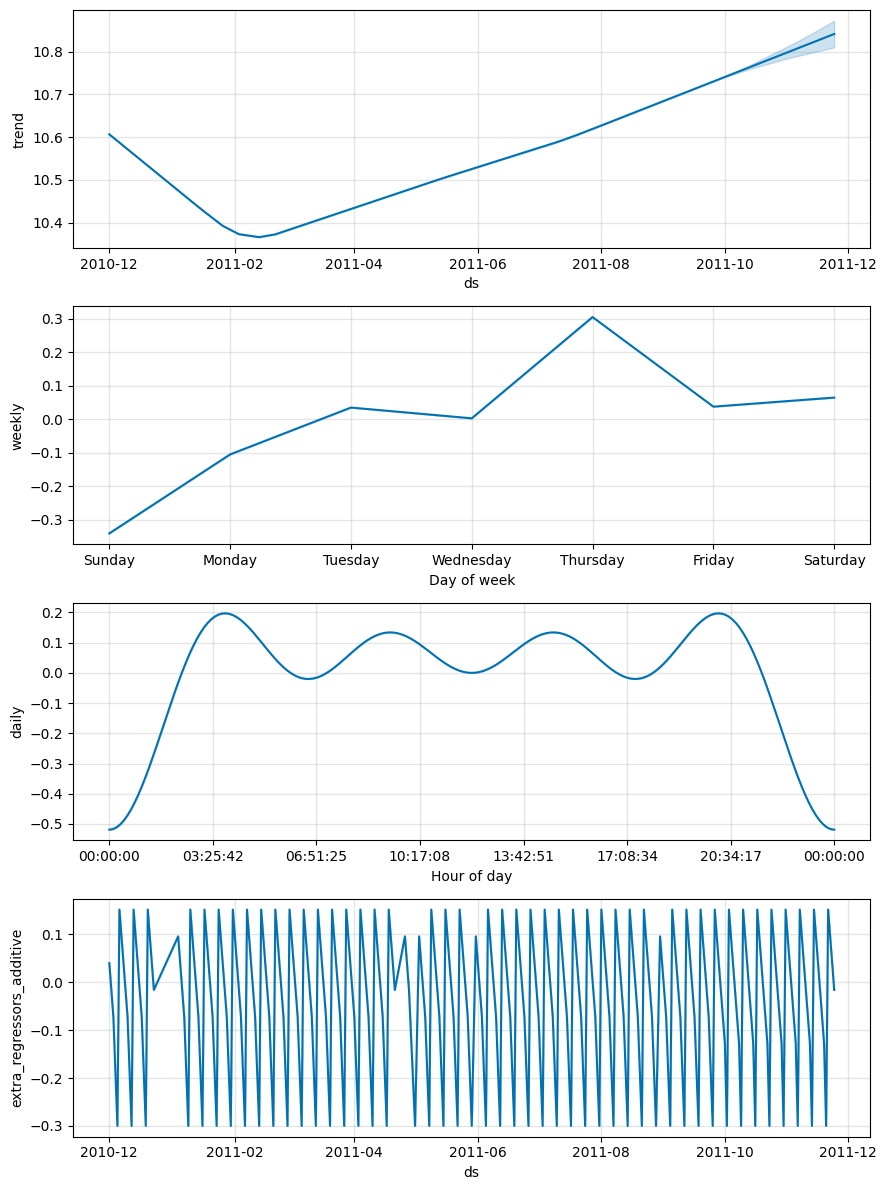

In [46]:
# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

According to the prediction line, overall sales is on the rise. For each week, sales is lowest on Sunday and highest on Thursday.

### Evaluate the model
The code evaluates the model's performance using mean absolute error (MAE), mean squared error (MSE), root mean squared error (RMSE), and normalized mean absolute error (NMAE). The actual vs. predicted sales plot compares the model's predictions with the test data.

In [47]:
y_true = np.expm1(test['y'].values)
y_pred = np.expm1(forecast['yhat'][-60:].values)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
nmae = mae / np.mean(y_true)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Normalized Mean Absolute Error (NMAE): {nmae:.2f}")

Mean Absolute Error (MAE): 15347.571549355518
Mean Squared Error (MSE): 365488027.8896213
Root Mean Squared Error (RMSE): 19117.741181677855
Normalized Mean Absolute Error (NMAE): 0.38


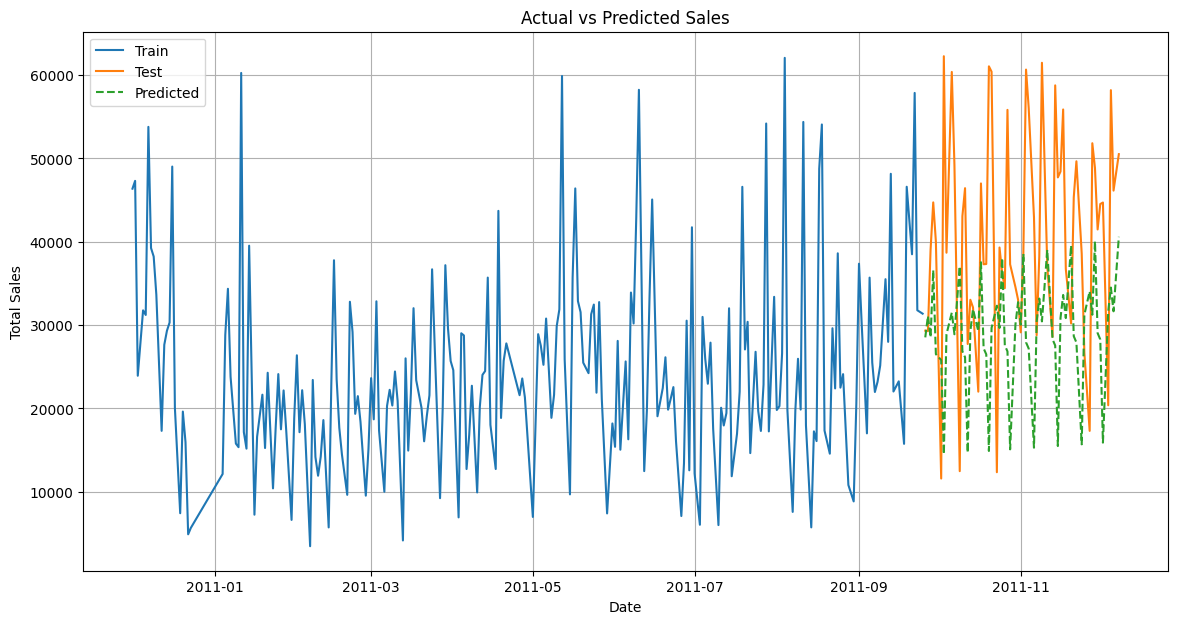

In [48]:
# Plot actual vs predicted sales
plt.figure(figsize=(14, 7))
plt.plot(train['ds'], np.expm1(train['y']), label='Train')
plt.plot(test['ds'], y_true, label='Test')
plt.plot(test['ds'], y_pred, label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()